In [232]:
import numpy as np
import matplotlib.pyplot as plt

In [233]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [234]:
# Models
def psf_model(x, y, x0, y0, sigma):
    """Scalar point-spread function"""
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    return np.exp(-r**2./2./sigma) / (2*np.pi*sigma)

def image_model(x, y, theta):
    """Calculate expected pixel count, using psf_model()."""
    F,b,x0,y0,sigma = theta
    return F * psf_model(x,y,x0,y0,sigma) + b

# Point source image generator
def make_image(params, xdim, ydim,noise=False):
    """Generate image from image_model"""
    F,b,source_x,source_y,sigma = params
    image = np.zeros((ydim,xdim))
    
    # Pixel locations
    x = np.arange(-xdim//2 + 1, xdim//2 + 1)
    y = np.arange(-ydim//2 + 1, ydim//2 + 1)
    
    # Evaluate image model at each pixel
    for i in range(ydim):
        for j in range(xdim):
            image[i,j] = image_model(x[j],y[i],params)
    
    # Add poisson noise if desired
    if noise: image = np.random.poisson(image);
    
    return image    

Total Flux:  3000.1195099511856


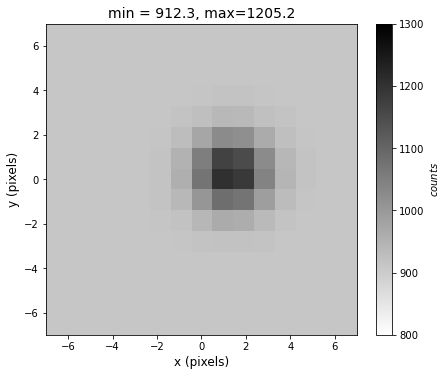

In [235]:
## Generate image for single source##
# Model parameters
Flux = 3000.12
sky_noise = 912.33
x0 = 1.4
y0 = 0.3
sigma = 1.5
theta = (Flux,sky_noise,x0,y0,sigma)

# Generate and plot image
image = make_image(theta, 15, 15)
print('Total Flux: ', np.sum(image - sky_noise))
plotCutout(image,clim=(800,1300))

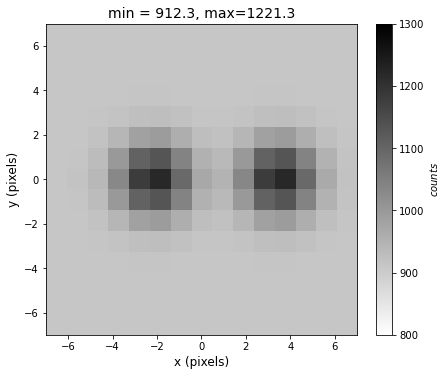

In [236]:
# Now, try two identical sources, along y = 0
theta_1 = (Flux,         0,  3.7, 0, sigma)
theta_2 = (Flux, sky_noise, -2.3, 0, sigma)
# Generate two images (remove background from one)
image_1 = make_image(theta_1, 15, 15)
image_2 = make_image(theta_2, 15, 15)

# Make composite image and plot
image_comp = image_1 + image_2
plotCutout(image_comp, clim=(800,1300))

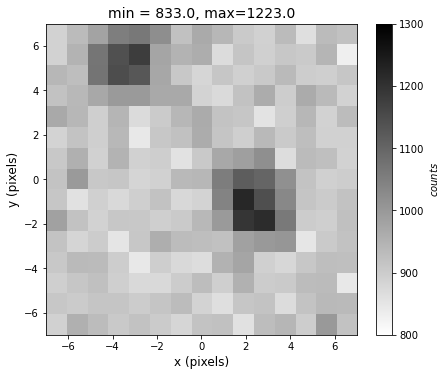

In [237]:
# Now, two different sources, and add poisson noise
theta_1 = (3000.12,    0.0,  2.3, -1.2, 1.5)
theta_2 = (2200.43, 912.33, -3.6,  5.8, 1.5)
# Generate two images (remove background from one)
image_1 = make_image(theta_1, 15, 15)
image_2 = make_image(theta_2, 15, 15)

# Make composite image and plot
image_comp = image_1 + image_2
image_comp = np.random.poisson(image_comp)
plotCutout(image_comp, clim=(800,1300))

In [238]:
# Let's try a trailed source.

# Calculate the point-source model at each point along a line-of-centroids and sum.
def trailed_model(x, y, params, npts = 10):
    """Calculate expected pixel count for trailed source"""
    F,b,xt,yt,xh,yh,sigma = params
    
    # Line of points
    xs = np.linspace(xt,xh,npts)
    ys = np.linspace(yt,yh,npts)
    
    pixel = 0.0
    for i in range(xs.size):
        pixel += psf_model(x, y, xs[i], ys[i], sigma)
    
    pixel *= F / npts
    pixel += b
    return pixel

def make_trailed_image(params, xdim, ydim, npts = None, noise=False):
    """Generate trailed source image."""
    F,b,xt,yt,xh,yh,sigma = params
    image = np.zeros((ydim,xdim))
    
    
    # Pixel positions ((0,0) center)
    x = np.arange(-xdim//2 + 1, xdim//2 + 1)
    y = np.arange(-ydim//2 + 1, ydim//2 + 1)
    
    # Choose npts adaptively
    if npts == None: npts = int(np.sqrt((xh - xt)**2 + (yh - yt)**2));
    
    # Evaluate trailed image model at each pixel
    for i in range(ydim):
        for j in range(xdim):
            image[i,j] = trailed_model(x[j],y[i],params,npts=npts)
    
    # Add poisson noise if desired
    if noise: image = np.random.poisson(image)
    
    return image

def chi_squared(params, data):
    """Calculate chi-squared, given a set of parameters and a data image."""
    xdim, ydim = data.shape
    model = make_trailed_image(params, xdim, ydim)
    return np.sum((data - model)**2 / model)

Total Flux:  9000.120000000456


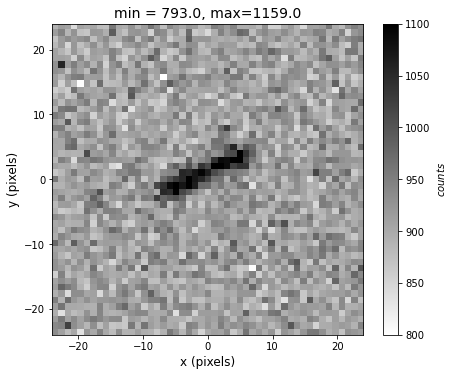

In [239]:
F = 9000.12
b = 912.55
x_t,y_t = -7,-2 # Beginning of trail centroid (Interchangeable with this model?)
x_h,y_h = 6,4   # End of trail centroid
sigma = 1.5
params = np.array([F,b,x_t,y_t,x_h,y_h,sigma])
xdim,ydim = 49,49

D = int(np.sqrt((head[0] - tail[0])**2 + (head[1] - tail[1])**2))
image = make_trailed_image(params, xdim, ydim, npts=D)
print('Total Flux: ', np.sum(image - 912.55))
image = np.random.poisson(image)
plotCutout(image,clim=(800,1100))

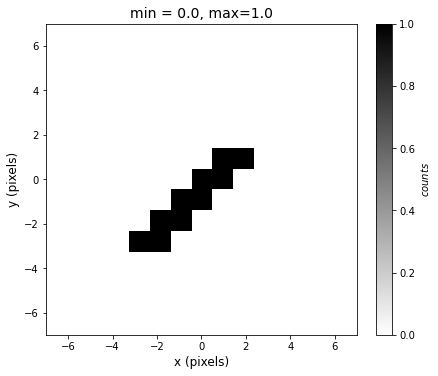

In [304]:
dim = 15
image_line = np.array([
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,1,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
])
plotCutout(image_line,clim=(0,1))

array([[-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-2., -2.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-1., -1.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [-0., -0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 2.,  2.],
       [ 2.,  2.],
       [ 2.,  2.],
       [ 2.,  2.],
       [ 2.,  2.],
       [ 2.,  2.],
       [ 2.,  2.]])

In [241]:
%%time
#print("Reduced chi-squared: ", chi_squared(params, image) / (image.size + len(params) - 1))
model = make_trailed_image(params, xdim, ydim)
#plotCutout(model, clim=(800,1100))
#plotCutout(image - model,clim=(-100,100))

CPU times: user 548 ms, sys: 6.83 ms, total: 555 ms
Wall time: 595 ms


# Optimization

In [140]:
import scipy.optimize as op

In [226]:
# Try scipy.optimize.minimize on chi_squared

# Generate 'data'
F = 9000.12
b = 912.55
tail = -4,-4 
head = 4,4
sigma = 1.5
params = np.array([F,b,*tail,*head,sigma])
xdim,ydim = 49,49
data = make_trailed_image(params, xdim, ydim, noise = False)

In [227]:
# Perturb parameters
F += np.random.randn()            # Flux
b += np.random.randn()            # Sky
tail = (-4,-4)                    # Tail
head = (4,4)                      # Head
sigma += np.random.randn() * 0.01 # Sigma
x0 = np.array([F,b,*tail,*head,sigma])

res = op.minimize(chi_squared,x0,args=(data))

KeyboardInterrupt: 

In [224]:
x0

array([ 9.00057691e+03,  9.10586353e+02, -4.00000000e+00, -4.00000000e+00,
        4.00000000e+00,  4.00000000e+00,  1.20917237e+00])

8836.269641810522
913.0012047964344
-3.6981522666918787
-3.9267182204667153
3.95167089943183
4.098744819040291
1.4655974865643302


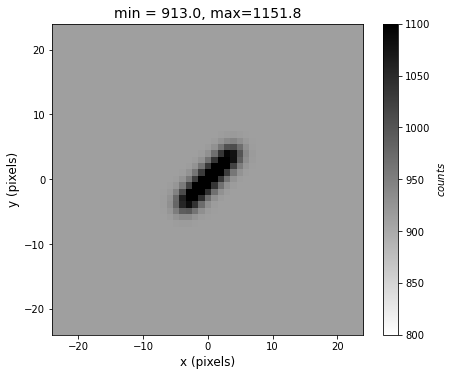

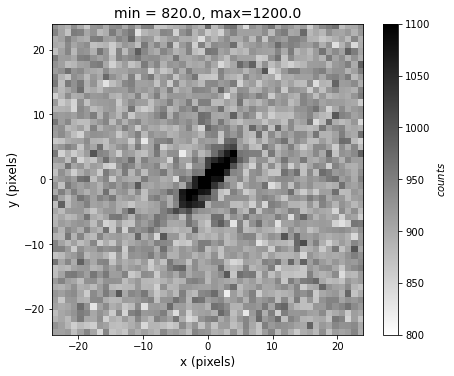

In [223]:
image_fit = make_trailed_image(res.x, xdim, ydim)
[print(x) for x in res.x]
plotCutout(image_fit, clim=(800,1100))
plotCutout(data,clim=(800,1100))

In [222]:
res.x

array([ 8.83626964e+03,  9.13001205e+02, -3.69815227e+00, -3.92671822e+00,
        3.95167090e+00,  4.09874482e+00,  1.46559749e+00])

In [217]:
# Now try least-squares
def lsq_cost(params, data):
    xdim, ydim = data.shape
    model = make_trailed_image(params, xdim, ydim)
    return (data - model).flatten()

lsq_fit = op.least_squares(lsq_cost, x0, args=(data,), method='lm')

Chi-squared:  2438.3729096376674
9484.574924652368
911.5003852878767
-3.8918548872188095
-4.014159410373187
3.9651398350505622
3.992346141241132
1.4756457561051015


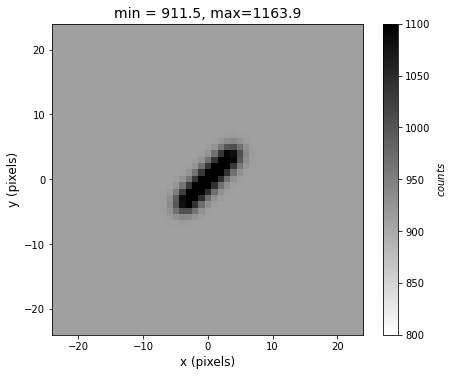

In [218]:
image_fit = make_trailed_image(lsq_fit.x, xdim, ydim)
print("Chi-squared: ", (np.sum(lsq_fit.fun**2 / image_fit.flatten())))
[print(x) for x in lsq_fit.x]
plotCutout(image_fit, clim=(800,1100))

# Multiple Streaks

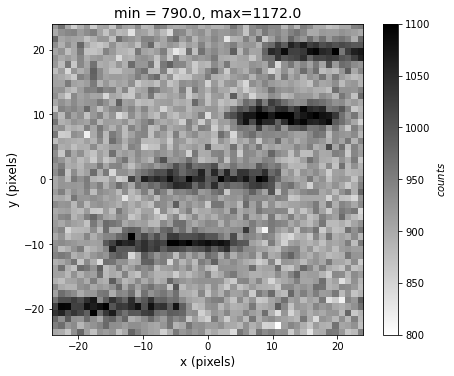

In [23]:
params_1 = (9000.12, 912.55, (-25,-20), (-5,-20), 1.5)
params_2 = (9000.12,    0.0, (-15,-10), (5,-10), 1.5)
params_3 = (9000.12,    0.0, (-10,0), (10,0), 1.5)
params_4 = (9000.12,    0.0, (5,10), (20,10), 1.5)
params_5 = (9000.12,    0.0, (10,20), (30,20), 1.5)
xdim,ydim = 49,49

im_1 = make_trailed_image(params_1, xdim, ydim, npts=15)
im_2 = make_trailed_image(params_2, xdim, ydim, npts=15)
im_3 = make_trailed_image(params_3, xdim, ydim, npts=15)
im_4 = make_trailed_image(params_4, xdim, ydim, npts=15)
im_5 = make_trailed_image(params_5, xdim, ydim, npts=15)
image_comp = im_1 + im_2 + im_3 + im_4 + im_5
image_comp = np.random.poisson(image_comp)

plotCutout(image_comp,clim=(800,1100))

Text(0, 0.5, '|True Flux - Calculated Flux|')

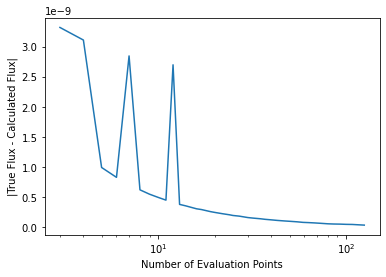

In [546]:
npts = np.zeros(50)
flux_sum = np.zeros(50)
for i,j in enumerate(np.logspace(0.5,2.1)):
    npts[i] = int(j)
    flux_sum[i] = abs(np.sum(make_trailed_image(params, xdim, ydim, npts=int(j)) - 912.55) - F)
plt.plot(npts,flux_sum)
plt.xscale('log')
plt.xlabel('Number of Evaluation Points')
plt.ylabel('|True Flux - Calculated Flux|')